In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import sys
import glob
import math
import os
MAX_MATCHES=30000
sys.setrecursionlimit(20000)


In [9]:
img_dir = r"C:\Users\bedab\OneDrive\AAU\Project\m" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
data = []
list_of_lists_of_images = []
for f1 in files:
    img1 = cv2.imread(f1)
    cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    data.append(img1)

w = 3
t = len(data)

for i in range(0, t//w):
    row = data[i*w:(i+1)*w]
    list_of_lists_of_images.append(row)

if t%w != 0:
    i=i+1
    row = data[i*w:-1]
    list_of_lists_of_images.append(row)
    


In [10]:
def find_homography(img1, img2, MIN_MATCH_COUNT = 4):
    img1 = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
    
    orb = cv2.ORB_create(MAX_MATCHES)
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
    
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.knnMatch(descriptors1,descriptors2,k=2)

    good = []
    for m,n in matches:
        if m.distance < .3*n.distance:
            good.append(m)
    print(len(good))
        


    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)    
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    else:
        print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))

    return M

In [11]:
def putImagesTogether(img1, img2, M):
   # M[0,2] = M[0,2] + img1.shape[1]
    #M[1,2] = M[1,2] + img1.shape[0]
    
    offset=np.array([[1, 0, img1.shape[1]],[0,1,img1.shape[0]],[0,0,1]])
    M=np.matmul(offset,M)
    dst = cv2.warpPerspective(img1,M,(img1.shape[1]*3, img1.shape[0]*3))
    dst[img2.shape[0]:img2.shape[0]*2,img2.shape[1]:img2.shape[1]*2,:] = img2
    
    return dst

def multiple(list_of_lists_of_images, homographys,connections, og_coordinate):
    offset_y=og_coordinate[0]*list_of_lists_of_images[0][0].shape[0]
    offset_x=og_coordinate[0]*list_of_lists_of_images[0][0].shape[1]
    w=list_of_lists_of_images[0][0].shape[1]
    h=list_of_lists_of_images[0][0].shape[0]
    offset=np.array([[1, 0, offset_x],[0,1,offset_y],[0,0,1]])
    
    result=np.zeros(((len(list_of_lists_of_images)*h),len(list_of_lists_of_images[0])*w,3),dtype='uint8')
    for i in range(0,len(homographys)):
        if connections[i][1]==og_coordinate:
            M=np.matmul(offset,homographys[i])
            print(result.shape)
            warped_image = cv2.warpPerspective(list_of_lists_of_images[connections[i][0][0]][connections[i][0][1]],M,(result.shape[1], result.shape[0]))
            print(warped_image.shape)
            result[warped_image!=0]=warped_image[warped_image!=0]
        result[offset_y:offset_y+h,offset_x:offset_x+w,:] =list_of_lists_of_images[og_coordinate[1]][og_coordinate[0]]    
        
            
            
    return result
    

In [12]:
homographys=[find_homography(list_of_lists_of_images[0][1],list_of_lists_of_images[1][1]),find_homography(list_of_lists_of_images[2][1],list_of_lists_of_images[1][1])]
print(homographys)
connections=[((0,1),(1,1)),((2,1),(1,1))]
og_coordinate=(1,1)
res=multiple(list_of_lists_of_images,homographys,connections,og_coordinate)

220
41
[array([[ 9.92728567e-01, -2.05733803e-02,  5.48874705e+01],
       [ 7.93547998e-03,  9.96398107e-01,  4.70415365e+02],
       [-9.38264212e-07, -6.88439032e-06,  1.00000000e+00]]), array([[ 1.00712422e+00, -3.81271859e-03,  5.62641957e-01],
       [ 1.03290600e-02,  9.70260828e-01, -7.21719543e+02],
       [ 5.33318217e-06,  1.54130755e-07,  1.00000000e+00]])]
(8928, 11904, 3)
(8928, 11904, 3)
(8928, 11904, 3)
(8928, 11904, 3)


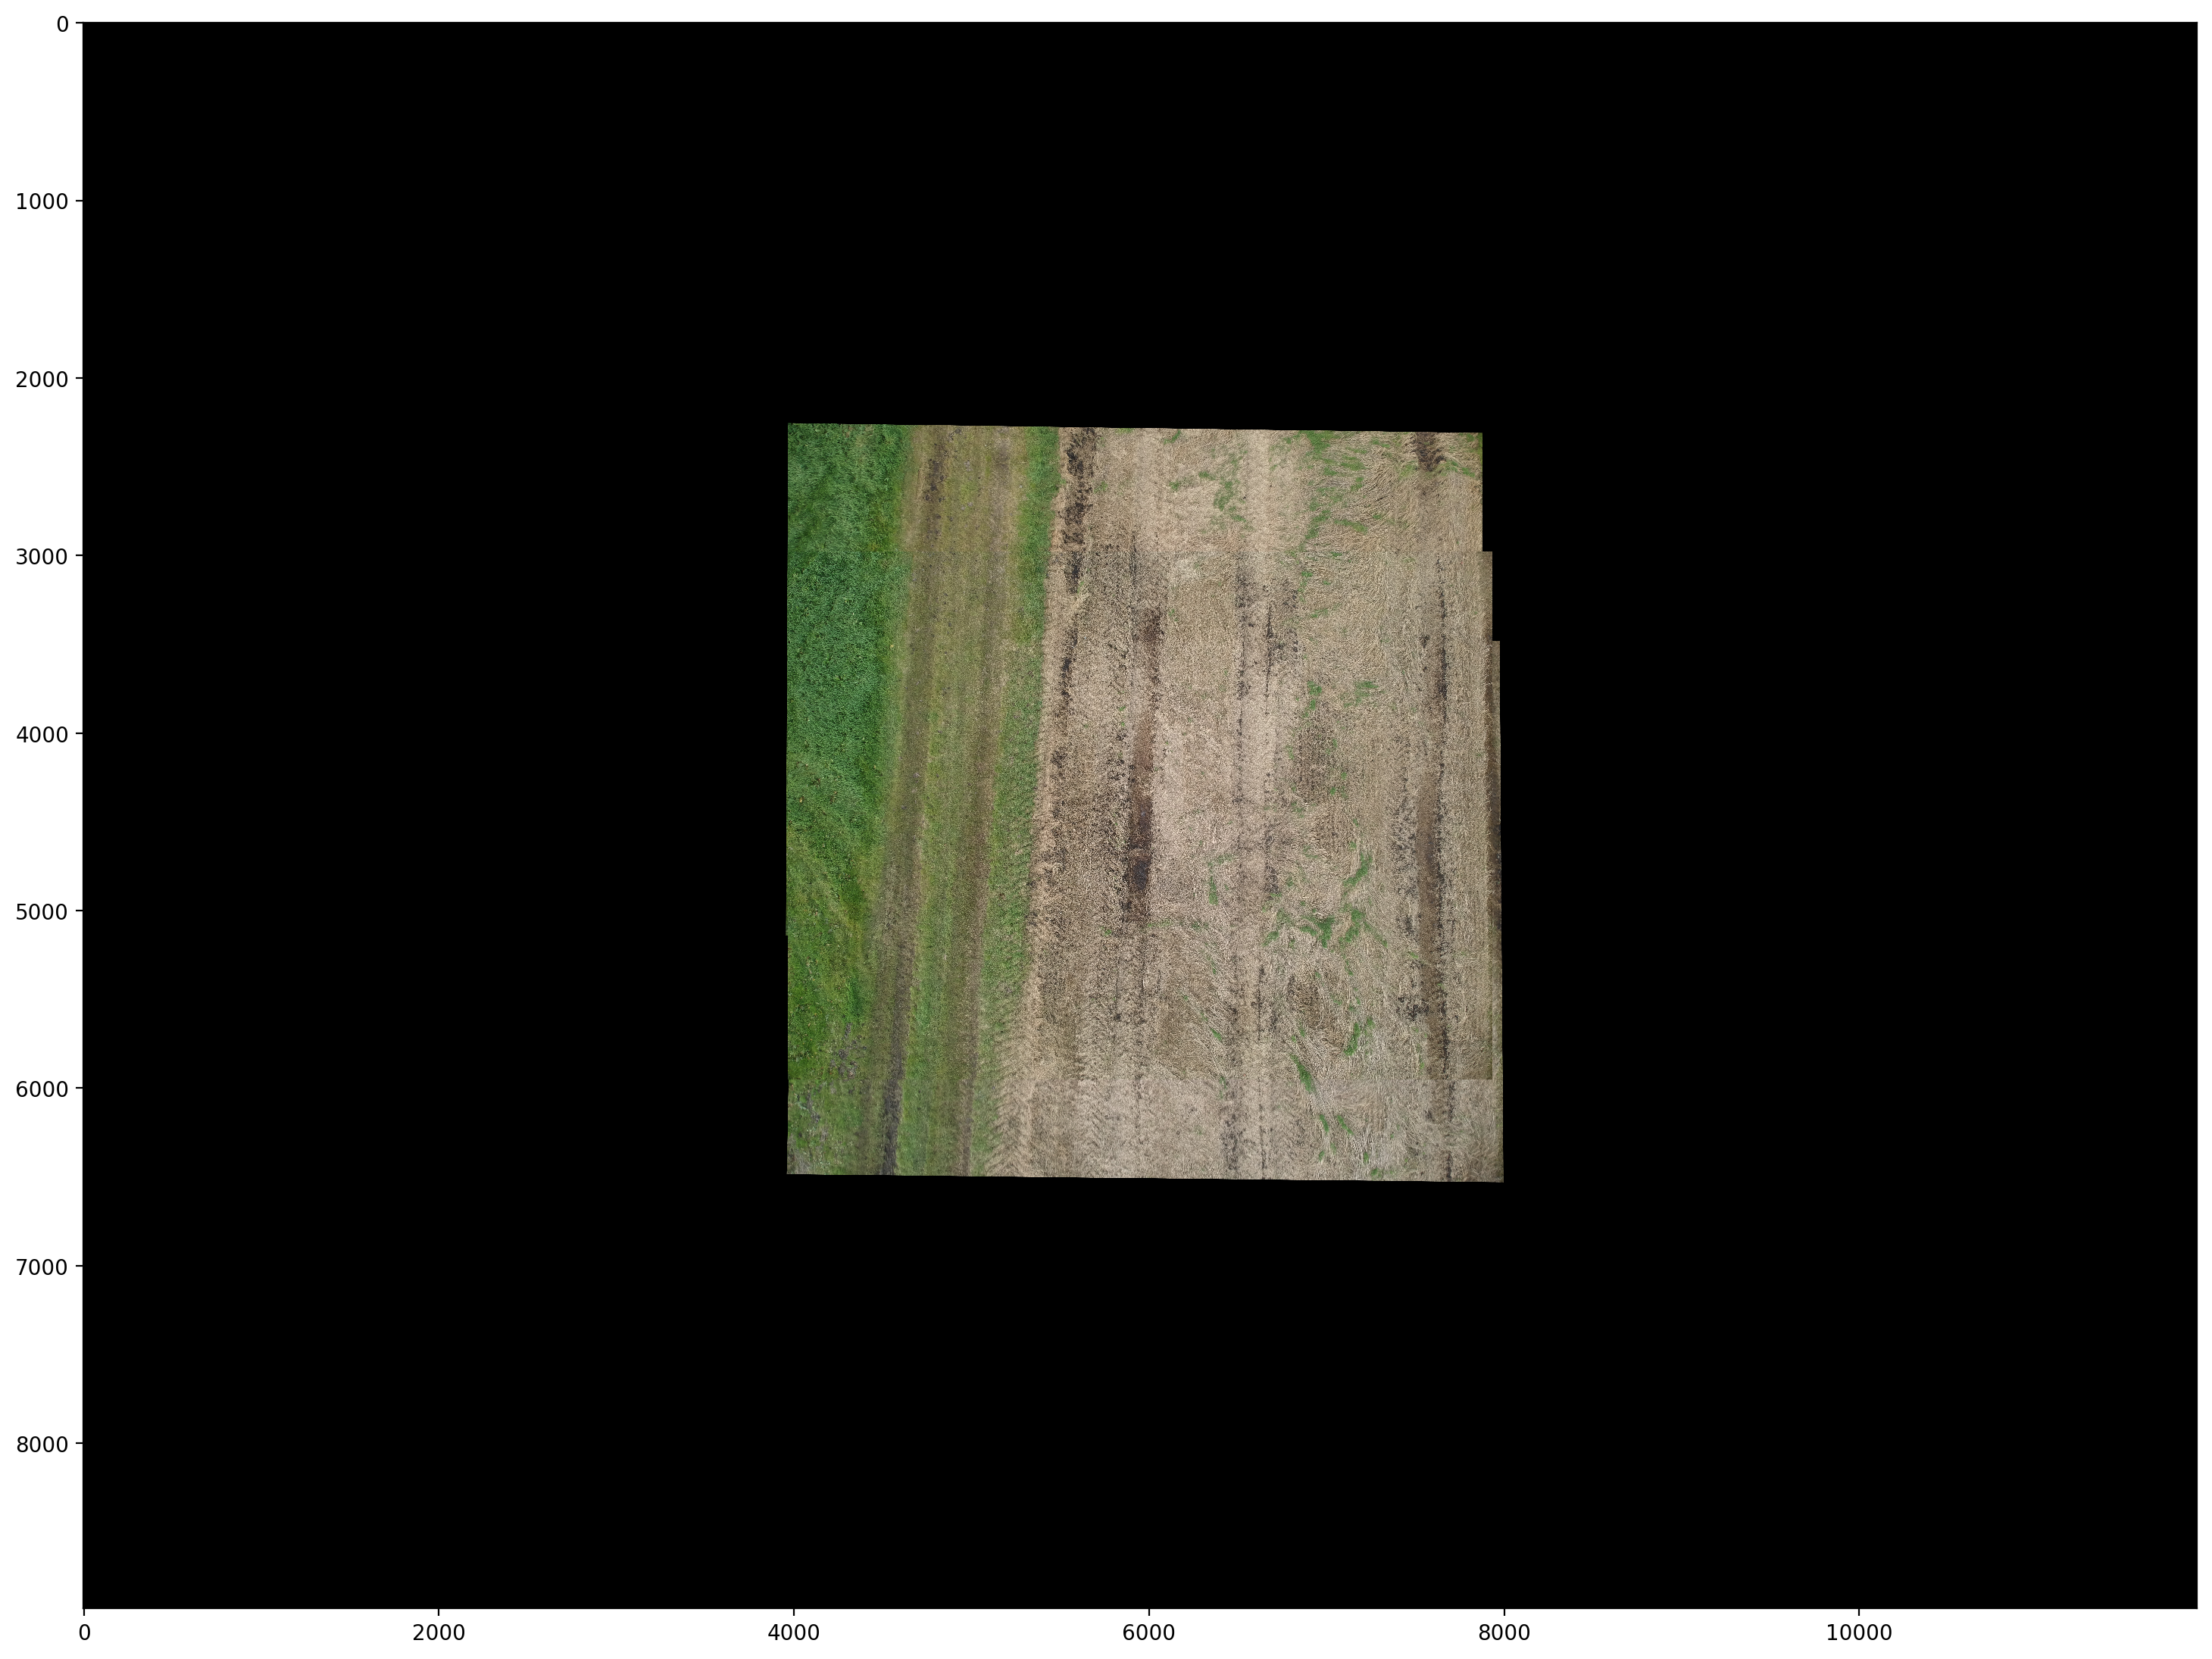

In [13]:
fig=plt.figure(figsize=(18, 16), dpi= 200, facecolor='w', edgecolor='k')  
cv2.imwrite('res.jpg',res)
plt.imshow(cv2.cvtColor(res,cv2.COLOR_BGR2RGB))

50000


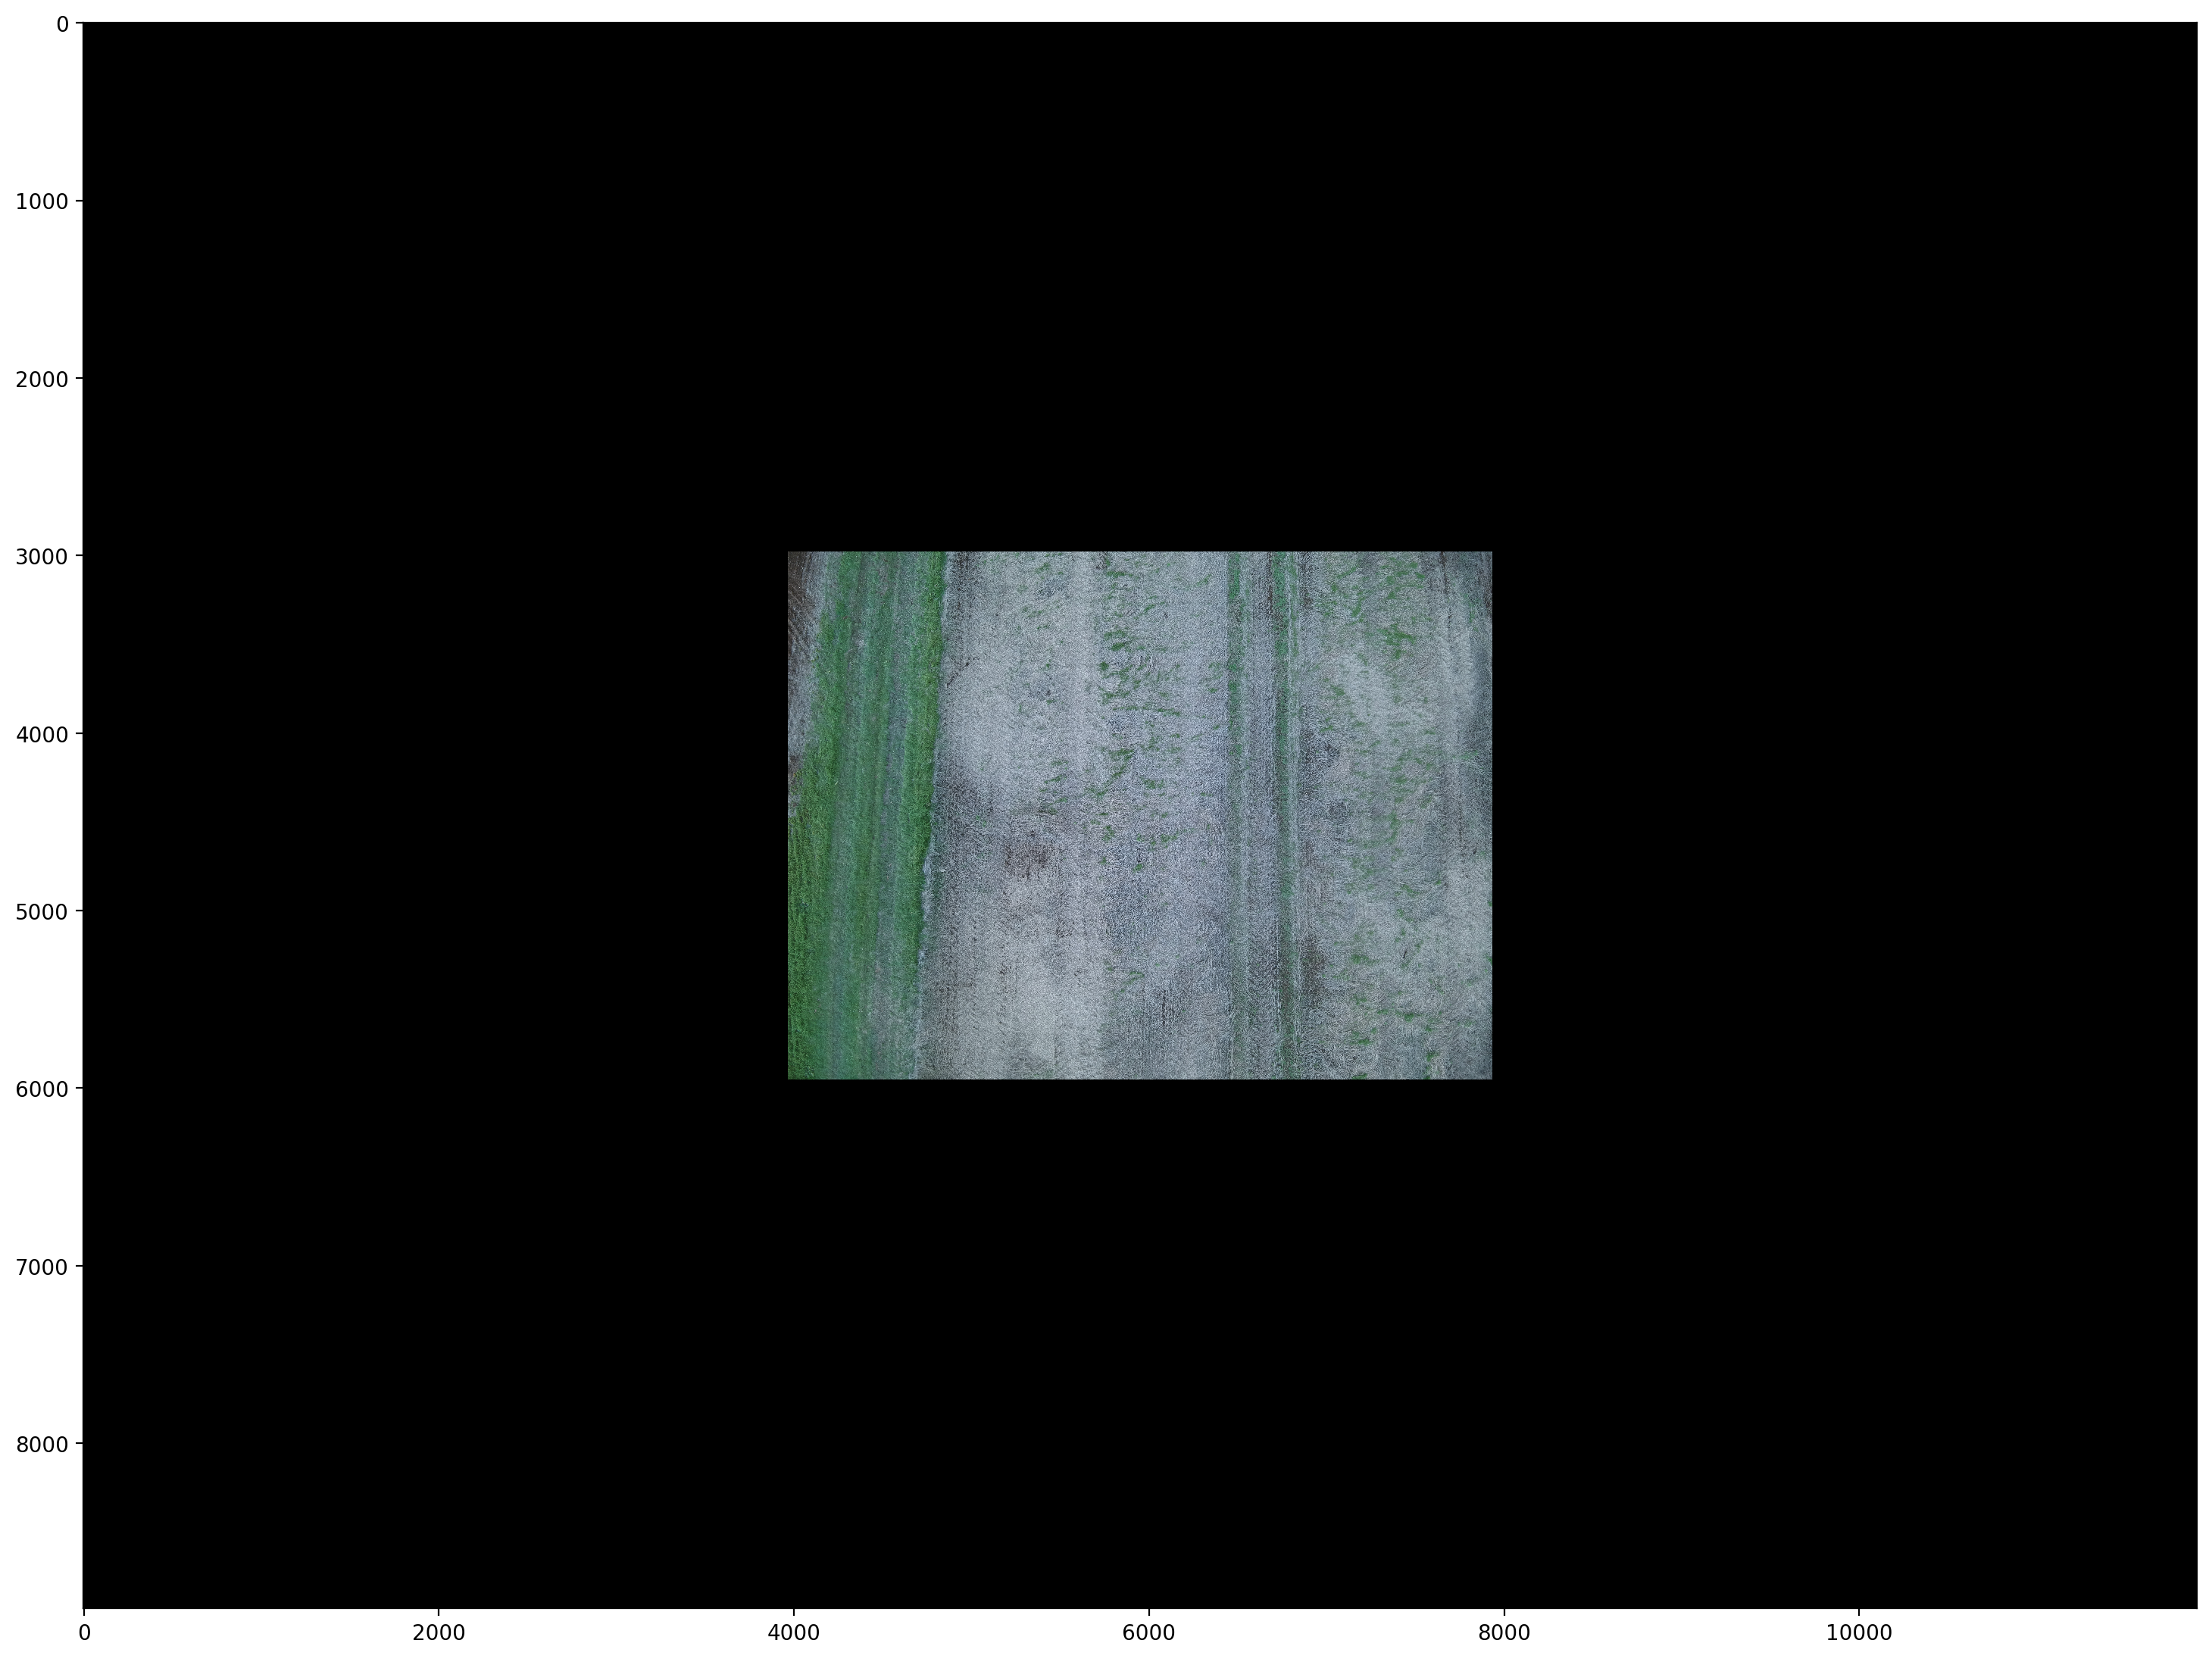

In [14]:
homography = find_homography(list_of_lists_of_images[0][0],list_of_lists_of_images[0][2])
resulting_image = putImagesTogether(list_of_lists_of_images[0][0],list_of_lists_of_images[0][2],homography)


fig=plt.figure(figsize=(18, 16), dpi= 200, facecolor='w', edgecolor='k')  
cv2.imwrite('image.jpg',resulting_image)
plt.imshow(resulting_image)

In [ ]:
def trim(frame):
    #crop top
    
    
    
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    elif not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    elif not np.sum(frame[:,0]):
        return trim(frame[:,1:]) 
    #crop right
    elif not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])    
    return frame



In [ ]:
 
trimmedimage=trim(g)

cv2.imwrite('drfghj.jpg',trimmedimage)